In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# 导入 alpha_utils 模块中的函数
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))
from alpha_utils import *

sns.set_style('whitegrid')
pd.options.display.float_format = '{:,.2f}'.format

### Import & Process data

In [2]:
data = pd.read_pickle('data/merged_df.pkl')
print(f"# Symbols: {len(data.index.unique('symbol')):,.0f} | # Dates: {len(data.index.unique('Date')):,.0f}")
data.info()

# Symbols: 20 | # Dates: 6,769
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 182763 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          182763 non-null  float64
 1   High          182763 non-null  float64
 2   Low           182763 non-null  float64
 3   Close         182763 non-null  float64
 4   Volume        182763 non-null  float64
 5   id            175994 non-null  object 
 6   symbol_meta   175994 non-null  object 
 7   name          175994 non-null  object 
 8   market_cap    175994 non-null  float64
 9   total_volume  175994 non-null  float64
dtypes: float64(7), object(3)
memory usage: 14.5+ MB


In [3]:
print("Symbols include: ", list(data.index.levels[0]))

Symbols include:  ['ADAUSDT', 'BNBUSDT', 'BTCUSDT', 'EOSUSDT', 'ETCUSDT', 'ETHUSDT', 'ICXUSDT', 'IOTAUSDT', 'LINKUSDT', 'LTCUSDT', 'NEOUSDT', 'NULSUSDT', 'ONTUSDT', 'QTUMUSDT', 'TRXUSDT', 'TUSDUSDT', 'USDCUSDT', 'VETUSDT', 'XLMUSDT', 'XRPUSDT']


In [4]:
# remove duplicates
duplicates = data.index.duplicated()
print(data[duplicates].index.unique('symbol'))
data = data[~data.index.duplicated()]
data.info()

Index(['EOSUSDT', 'ETHUSDT', 'USDCUSDT'], dtype='object', name='symbol')
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135380 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-09 00:00:00+0000', tz='UTC'))
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135380 non-null  float64
 1   High          135380 non-null  float64
 2   Low           135380 non-null  float64
 3   Close         135380 non-null  float64
 4   Volume        135380 non-null  float64
 5   id            128611 non-null  object 
 6   symbol_meta   128611 non-null  object 
 7   name          128611 non-null  object 
 8   market_cap    128611 non-null  float64
 9   total_volume  128611 non-null  float64
dtypes: float64(7), object(3)
memory usage: 10.8+ MB


In [5]:
by_symbol = data.groupby(level='symbol')

In [6]:
# Historical returns
T = [1, 2, 3, 4, 5, 12, 24, 48, 72, 168]
for t in T:
    data[f'ret_{t:02}'] = by_symbol.Close.pct_change(t)

In [7]:
# Forward returns
data['ret_fwd'] = by_symbol.ret_01.shift(-1)
data = data.dropna(subset=['ret_fwd'])

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 135360 entries, ('ADAUSDT', Timestamp('2024-07-01 00:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-08 23:00:00+0000', tz='UTC'))
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Open          135360 non-null  float64
 1   High          135360 non-null  float64
 2   Low           135360 non-null  float64
 3   Close         135360 non-null  float64
 4   Volume        135360 non-null  float64
 5   id            128592 non-null  object 
 6   symbol_meta   128592 non-null  object 
 7   name          128592 non-null  object 
 8   market_cap    128592 non-null  float64
 9   total_volume  128592 non-null  float64
 10  ret_01        135340 non-null  float64
 11  ret_02        135320 non-null  float64
 12  ret_03        135300 non-null  float64
 13  ret_04        135280 non-null  float64
 14  ret_05        135260 non-null  float64
 15  ret_12        135120 no

In [9]:
o = data.Open.unstack('symbol')
h = data.High.unstack('symbol')
l = data.Low.unstack('symbol')
c = data.Close.unstack('symbol')
v = data.Volume.unstack('symbol')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.ret_01.unstack('symbol')

### Alpha 001
```
rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5))
```

Alpha#1 的逻辑是：

- 针对每个股票，选择一个基础指标：当收益为负时用波动性（标准差），否则用收盘价；

- 通过平方操作放大信号差异；

- 在短期内（5个period）找出该信号的峰值出现时间，作为时间特征；

- 最后通过横截面排序标准化信号，得到每个股票该period的因子值。

In [10]:
alpha = 1

In [11]:
def alpha001(c, r):
    """(rank(ts_argmax(power(((returns < 0)
        ? ts_std(returns, 20)
        : close), 2.), 5)) -0.5)"""
    c[r < 0] = ts_std(r, 24)
    return ( rank(ts_argmax(power(c, 2), 12)).mul(-.5) # modified period parameters for hourly data
            .stack().swaplevel() )

In [12]:
alphas = data[['ret_01', 'ret_fwd']].copy()

In [13]:
%%time
alphas[f'{alpha:03}'] = alpha001(c, r)

CPU times: total: 5.22 s
Wall time: 5.33 s


In [14]:
alphas.dropna(inplace=True)

In [15]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 134663 entries, ('ADAUSDT', Timestamp('2024-07-02 11:00:00+0000', tz='UTC')) to ('XRPUSDT', Timestamp('2025-04-08 23:00:00+0000', tz='UTC'))
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ret_01   134663 non-null  float64
 1   ret_fwd  134663 non-null  float64
 2   001      134663 non-null  float64
dtypes: float64(3)
memory usage: 3.5+ MB


#### Distribution visualization

<Axes: xlabel='001', ylabel='Count'>

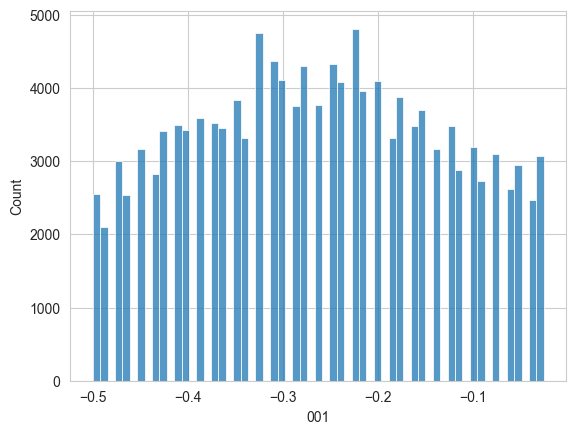

In [16]:
sns.histplot(alphas[f"{alpha:03}"])

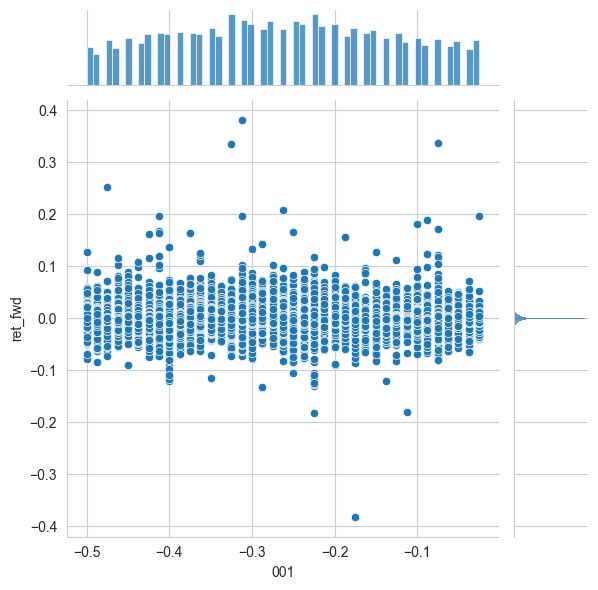

In [17]:
g = sns.jointplot(x=f"{alpha:03}", y='ret_fwd', data=alphas)

#### Correlation with future return

In [18]:
alphas[f"{alpha:03}"].corr(alphas['ret_fwd'])

np.float64(-0.0008038961279941909)

#### Regression

In [19]:
X = sm.add_constant(alphas[f"{alpha:03}"])
model = sm.OLS(alphas['ret_fwd'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_fwd   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.08702
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.768
Time:                        10:25:56   Log-Likelihood:             4.2446e+05
No. Observations:              134663   AIC:                        -8.489e+05
Df Residuals:                  134661   BIC:                        -8.489e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.087e-05   6.33e-05      0.172      0.8

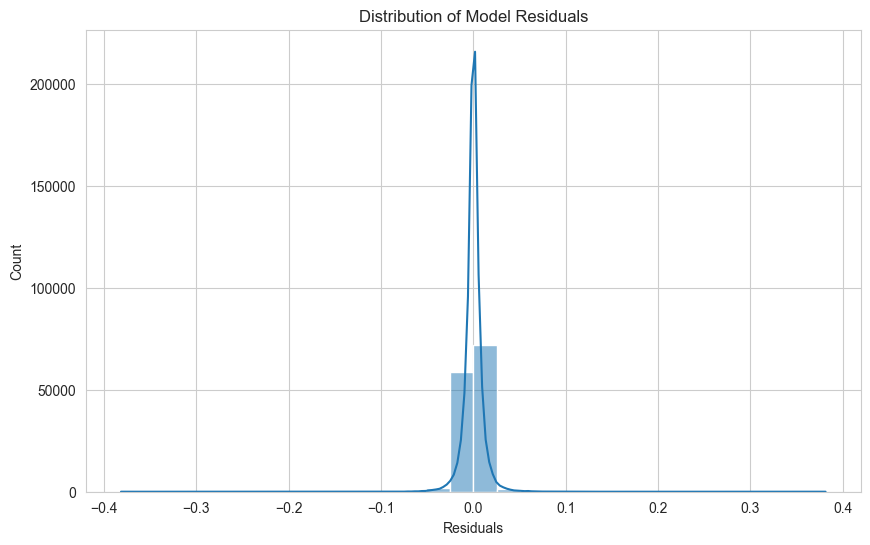

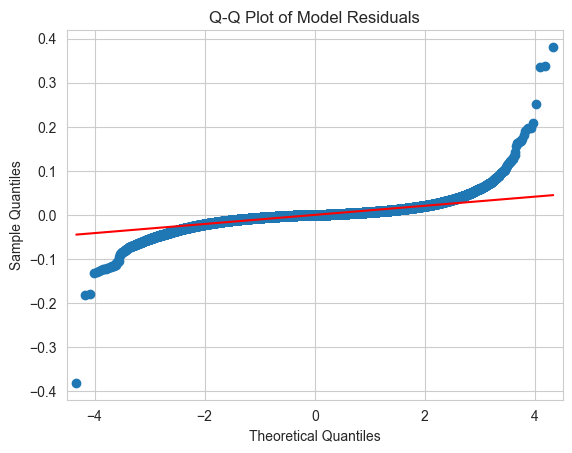

In [20]:
residuals = model.resid

# 1. 绘制直方图和 KDE 曲线
plt.figure(figsize=(10,6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Model Residuals")
plt.show()

# 2. 绘制 Q-Q 图，检查正态性
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Model Residuals")
plt.show()

### Evaluation for BTC

In [21]:
btc_data = alphas.loc['BTCUSDT'].loc['2025-03-01':'2025-03-31']
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-03-01 00:00:00+00:00 to 2025-03-31 23:00:00+00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ret_01   744 non-null    float64
 1   ret_fwd  744 non-null    float64
 2   001      744 non-null    float64
dtypes: float64(3)
memory usage: 23.2 KB


<Axes: xlabel='001', ylabel='Count'>

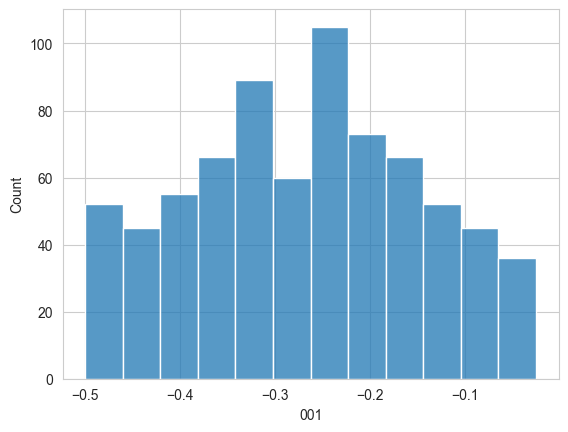

In [22]:
sns.histplot(btc_data[f"{alpha:03}"])

In [23]:
btc_data[f"{alpha:03}"].corr(btc_data['ret_fwd'])

np.float64(-0.016307781588613488)

In [24]:
X = sm.add_constant(btc_data[f"{alpha:03}"])
model = sm.OLS(btc_data['ret_fwd'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_fwd   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1974
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.657
Time:                        10:25:57   Log-Likelihood:                 2663.3
No. Observations:                 744   AIC:                            -5323.
Df Residuals:                     742   BIC:                            -5313.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.400      0.6

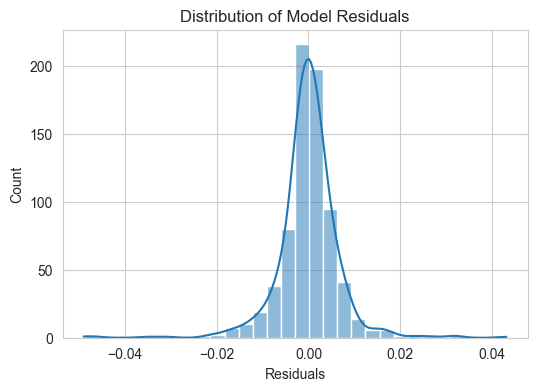

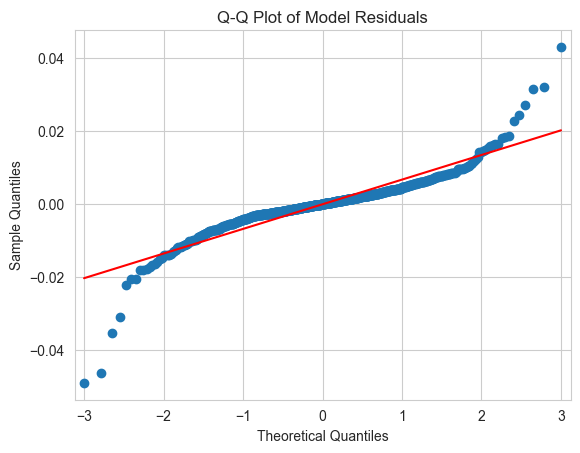

In [25]:
residuals = model.resid

# 1. 绘制直方图和 KDE 曲线
plt.figure(figsize=(6,4))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Model Residuals")
plt.show()

# 2. 绘制 Q-Q 图，检查正态性
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Model Residuals")
plt.show()

### Evaluation for ETH

In [26]:
eth_data = alphas.loc['ETHUSDT'].loc['2025-01-01':'2025-01-31']
eth_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-01-01 00:00:00+00:00 to 2025-01-31 23:00:00+00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ret_01   744 non-null    float64
 1   ret_fwd  744 non-null    float64
 2   001      744 non-null    float64
dtypes: float64(3)
memory usage: 23.2 KB


<Axes: xlabel='001', ylabel='Count'>

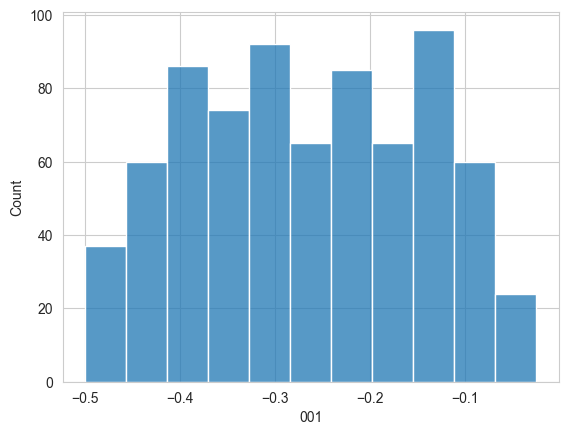

In [27]:
sns.histplot(eth_data[f"{alpha:03}"])

In [28]:
eth_data[f"{alpha:03}"].corr(eth_data['ret_fwd'])

np.float64(-0.03368831111154768)

In [29]:
X = sm.add_constant(eth_data[f"{alpha:03}"])
model = sm.OLS(eth_data['ret_fwd'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_fwd   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8431
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.359
Time:                        10:25:58   Log-Likelihood:                 2601.5
No. Observations:                 744   AIC:                            -5199.
Df Residuals:                     742   BIC:                            -5190.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.821      0.4

### Evaluation for ADA

In [31]:
ada_data = alphas.loc['ADAUSDT'].loc['2025-01-01':'2025-01-31']
ada_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2025-01-01 00:00:00+00:00 to 2025-01-31 23:00:00+00:00
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ret_01   744 non-null    float64
 1   ret_fwd  744 non-null    float64
 2   001      744 non-null    float64
dtypes: float64(3)
memory usage: 23.2 KB


<Axes: xlabel='001', ylabel='Count'>

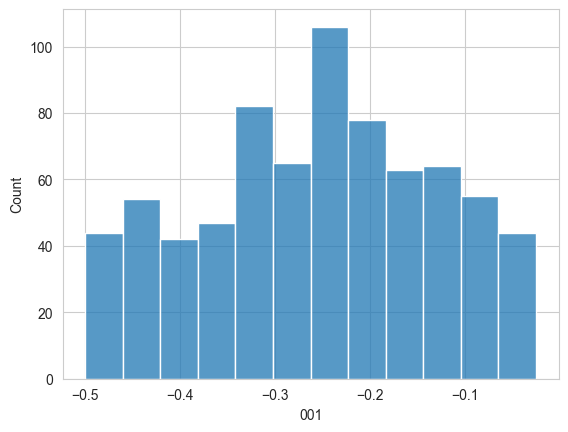

In [32]:
sns.histplot(ada_data[f"{alpha:03}"])

In [33]:
ada_data[f"{alpha:03}"].corr(ada_data['ret_fwd'])

np.float64(0.005603918990826663)

In [34]:
X = sm.add_constant(ada_data[f"{alpha:03}"])
model = sm.OLS(ada_data['ret_fwd'], X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                ret_fwd   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.02330
Date:                Wed, 09 Apr 2025   Prob (F-statistic):              0.879
Time:                        10:29:37   Log-Likelihood:                 2258.4
No. Observations:                 744   AIC:                            -4513.
Df Residuals:                     742   BIC:                            -4503.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.340      0.7